In [1]:
# SYSTEM
from os import sys, cpu_count
from time import time
from multiprocessing import Process
from multiprocessing.shared_memory import SharedMemory

# DATA TOOLS
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift
from sklearn.linear_model import  LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# PACKAGE CONFIG
mpl.rcParams.update({'font.size':16})

In [2]:
# MULTIPROCESSING DEFINTIONS

"""
MP TEST FUNCTION
def is_even(ARRAY,OUTPUT):
    for i in range(len(ARRAY)):   
        if (np.round(ARRAY[i]) % 2) == 0.0:
            OUTPUT[i] = 1
        else:
            OUTPUT[i] = 0
"""

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[0]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[0] - distance
    return work_schedule

"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT_ARRAY, TASK, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        print(f'start {i}')
        position = WORK_SCHEDULE[i,0]
        magnitude = WORK_SCHEDULE[i,1]
        jobslice = INPUT_ARRAY[position:int(position+magnitude)]
        jobslice_str = str(jobslice)
        outslice = OUTPUT[position:int(position+magnitude)]
        p = Process(target=TASK, args=(jobslice,outslice))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        print(f'join {i}')
        processes[i].join()

In [3]:
df = pd.read_csv('./input/train.csv')

In [4]:
# An array of the cumulative inflation rates for the years 2006-2010 until 2021
# IE between 2006 and 2021 there is a cumlative rate of inflation equal to 29.8%
inflation2021 = np.array([[2006,0.29752976],
                          [2007,0.26159678],
                          [2008,0.21494824],
                          [2009,0.21928618],
                          [2010,0.19960927]])

# Function which, given YrSold, converts associated value of SalePrice
# by accounting for inflation. A Box-Cox transform is then performed on
# the adjusted value to make the distribution more normal looking.
def adj4inf(YEAR, DOLLARS):
    for i in range(len(inflation2021)):
        if YEAR == inflation2021[i,0]:
            adjvalue = DOLLARS*(1+inflation2021[i,1])
            break
    return np.log(adjvalue) # Note the logarithm feat. Box-Cox(1964)
df.shape

(1460, 81)

In [5]:
if 'adjprice' in df:
    None
else:
    adjprices = []
    for i in range(len(df)):
        adjprices.append(adj4inf(df['YrSold'][i],df['SalePrice'][i]))
    df.insert(loc=81,column='adjprice',value=adjprices)
    del adjprices
df.iloc[0:5,70:]

ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold  \
0            0         0    NaN   NaN         NaN        0       2    2008   
1            0         0    NaN   NaN         NaN        0       5    2007   
2            0         0    NaN   NaN         NaN        0       9    2008   
3            0         0    NaN   NaN         NaN        0       2    2006   
4            0         0    NaN   NaN         NaN        0      12    2008   

  SaleType SaleCondition  SalePrice   adjprice  
0       WD        Normal     208500  12.442396  
1       WD        Normal     181500  12.341389  
2       WD        Normal     223500  12.511868  
3       WD       Abnorml     140000  12.109860  
4       WD        Normal     250000  12.623918

p = 2.81836e-06
The null hypothesis can be rejected


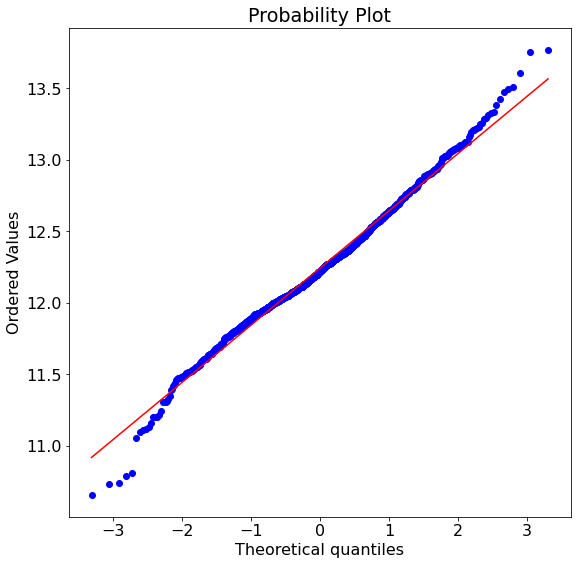

In [6]:
#target, lamda = stats.boxcox(np.array(df['adjprice']))
#target = np.array(df[df[VAR] == '2Story']['SalePrice'])
target = np.array(df['adjprice'])

k2, p = stats.normaltest(target)
alpha = 50e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
fig, ax = plt.subplots(figsize= (9,9))
stats.probplot(target,plot=ax)
plt.show()

# Missing Values 

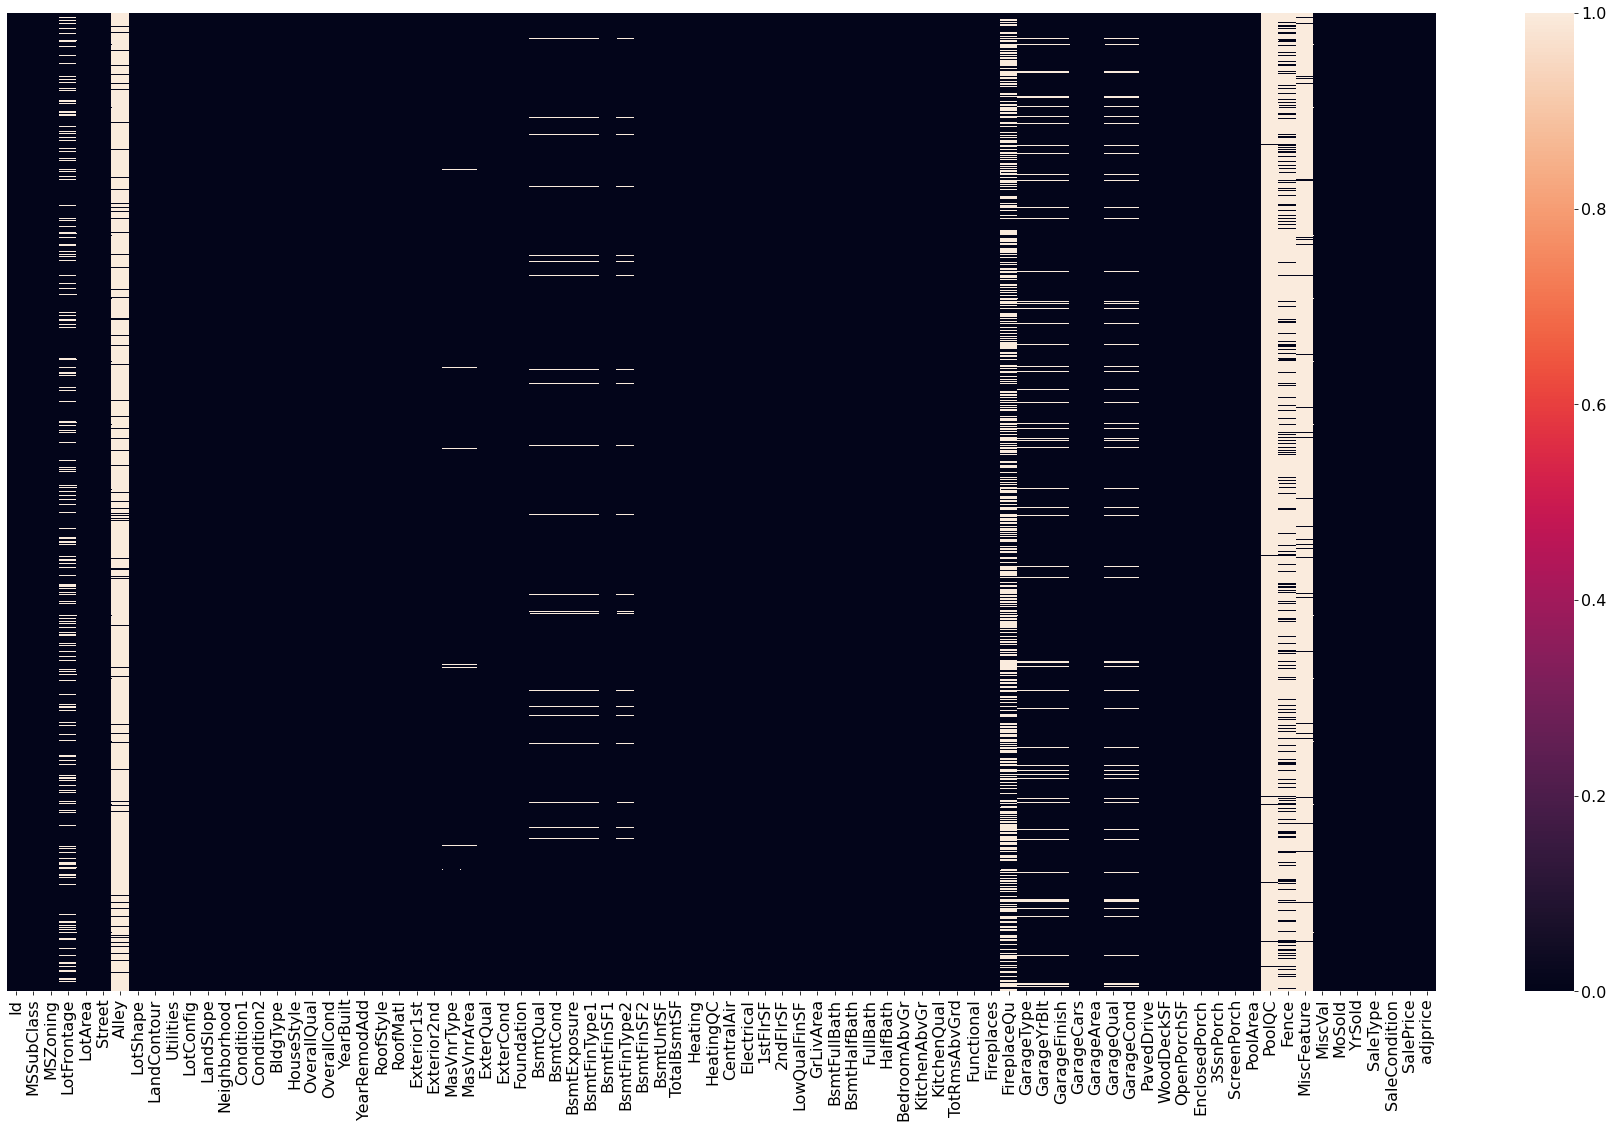

In [7]:
plt.figure(figsize=(32,18))
sns.heatmap(df.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

In [8]:
df.columns[df.isnull().any() == True]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## LotFrontage

A NaN for LotFrontage could indicate may indicate there is no street access to the parcel. Since zero of the parcels which have an NaN for LotFrontage have a NaN for Street type, I will replace the NaN in LotFrontage with the product of the mean frontage ratio for all data and the LotArea where the LotFrontage is missing.

In [9]:
mean_frontage_ratio = np.mean(df['LotFrontage']/df['LotArea'])
df['LotFrontage'].replace(np.nan,mean_frontage_ratio*df['LotArea'],inplace=True)

In [10]:
df.columns[df.isnull().any() == True]

Index(['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## Alley

In [11]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [12]:
df['Alley'].replace(np.nan,'None',inplace=True)

##  MasVnrType, MasVnrArea

In [13]:
df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [14]:
df['MasVnrArea'].replace(np.nan,0,inplace=True)
df['MasVnrType'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [15]:
df['BsmtQual'].replace(np.nan,'None',inplace=True)
df['BsmtCond'].replace(np.nan,'None',inplace=True)
df['BsmtExposure'].replace(np.nan,'None',inplace=True)
df['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df['BsmtFinType2'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## Electrical

In [16]:
df[df['Electrical'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1379  1380          80       RL         73.0     9735   Pave  None      Reg   

     LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold  \
1379         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   

     YrSold SaleType  SaleCondition  SalePrice  adjprice  
1379   2008       WD         Normal     167500  12.22344  

[1 rows x 82 columns]

In [17]:
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [18]:
df['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df.columns[df.isnull().any() == True]

Index(['FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## FireplaceQu

In [19]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [20]:
len(df[df['FireplaceQu'].isnull() & df['Fireplaces'] != 0])

0

In [21]:
df['FireplaceQu'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

In [22]:
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageYrBlt'].replace(np.nan,df['GarageYrBlt'].mean(),inplace=True)
df['GarageFinish'].replace(np.nan,'None',inplace=True)
df['GarageQual'].replace(np.nan,'None',inplace=True)
df['GarageCond'].replace(np.nan,'None',inplace=True)

df.columns[df.isnull().any() == True]

Index(['PoolQC', 'Fence', 'MiscFeature'], dtype='object')

## PoolQC

In [23]:
len(df[df['PoolQC'].isnull() & df['PoolArea'] != 0])

0

In [24]:
df['PoolQC'].replace(np.nan,'None',inplace=True)

## Fence

In [25]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [26]:
df['Fence'].replace(np.nan,'None',inplace=True)

## MiscFeature

In [27]:
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [28]:
df['MiscFeature'].replace(np.nan,'None',inplace=True)

In [29]:
#!rm datatypes.npy

In [30]:
# datatype array contains what type of data is contained in each column of df
#
# KEY
# ==========
# 0 - nominal
# 1 - ordinal
# 2 - interval
# 3 - ratio

try:
    with open('./datatypes.npy','rb') as f:
        datatype = np.load(f)
except:
    datatype = np.zeros(len(df.columns))
    for i in range(len(df.columns)):
        datatype[i] = input(f'{df.columns[i]}')
        np.save('./datatypes.npy',datatype)
datatype[0:5]

array([3., 0., 0., 3., 3.])

In [31]:
categoric = []
numeric = []
for i in range(len(datatype)):
    if datatype[i] <= 1:
        categoric.append(df.columns[i])
    else:
        numeric.append(df.columns[i])

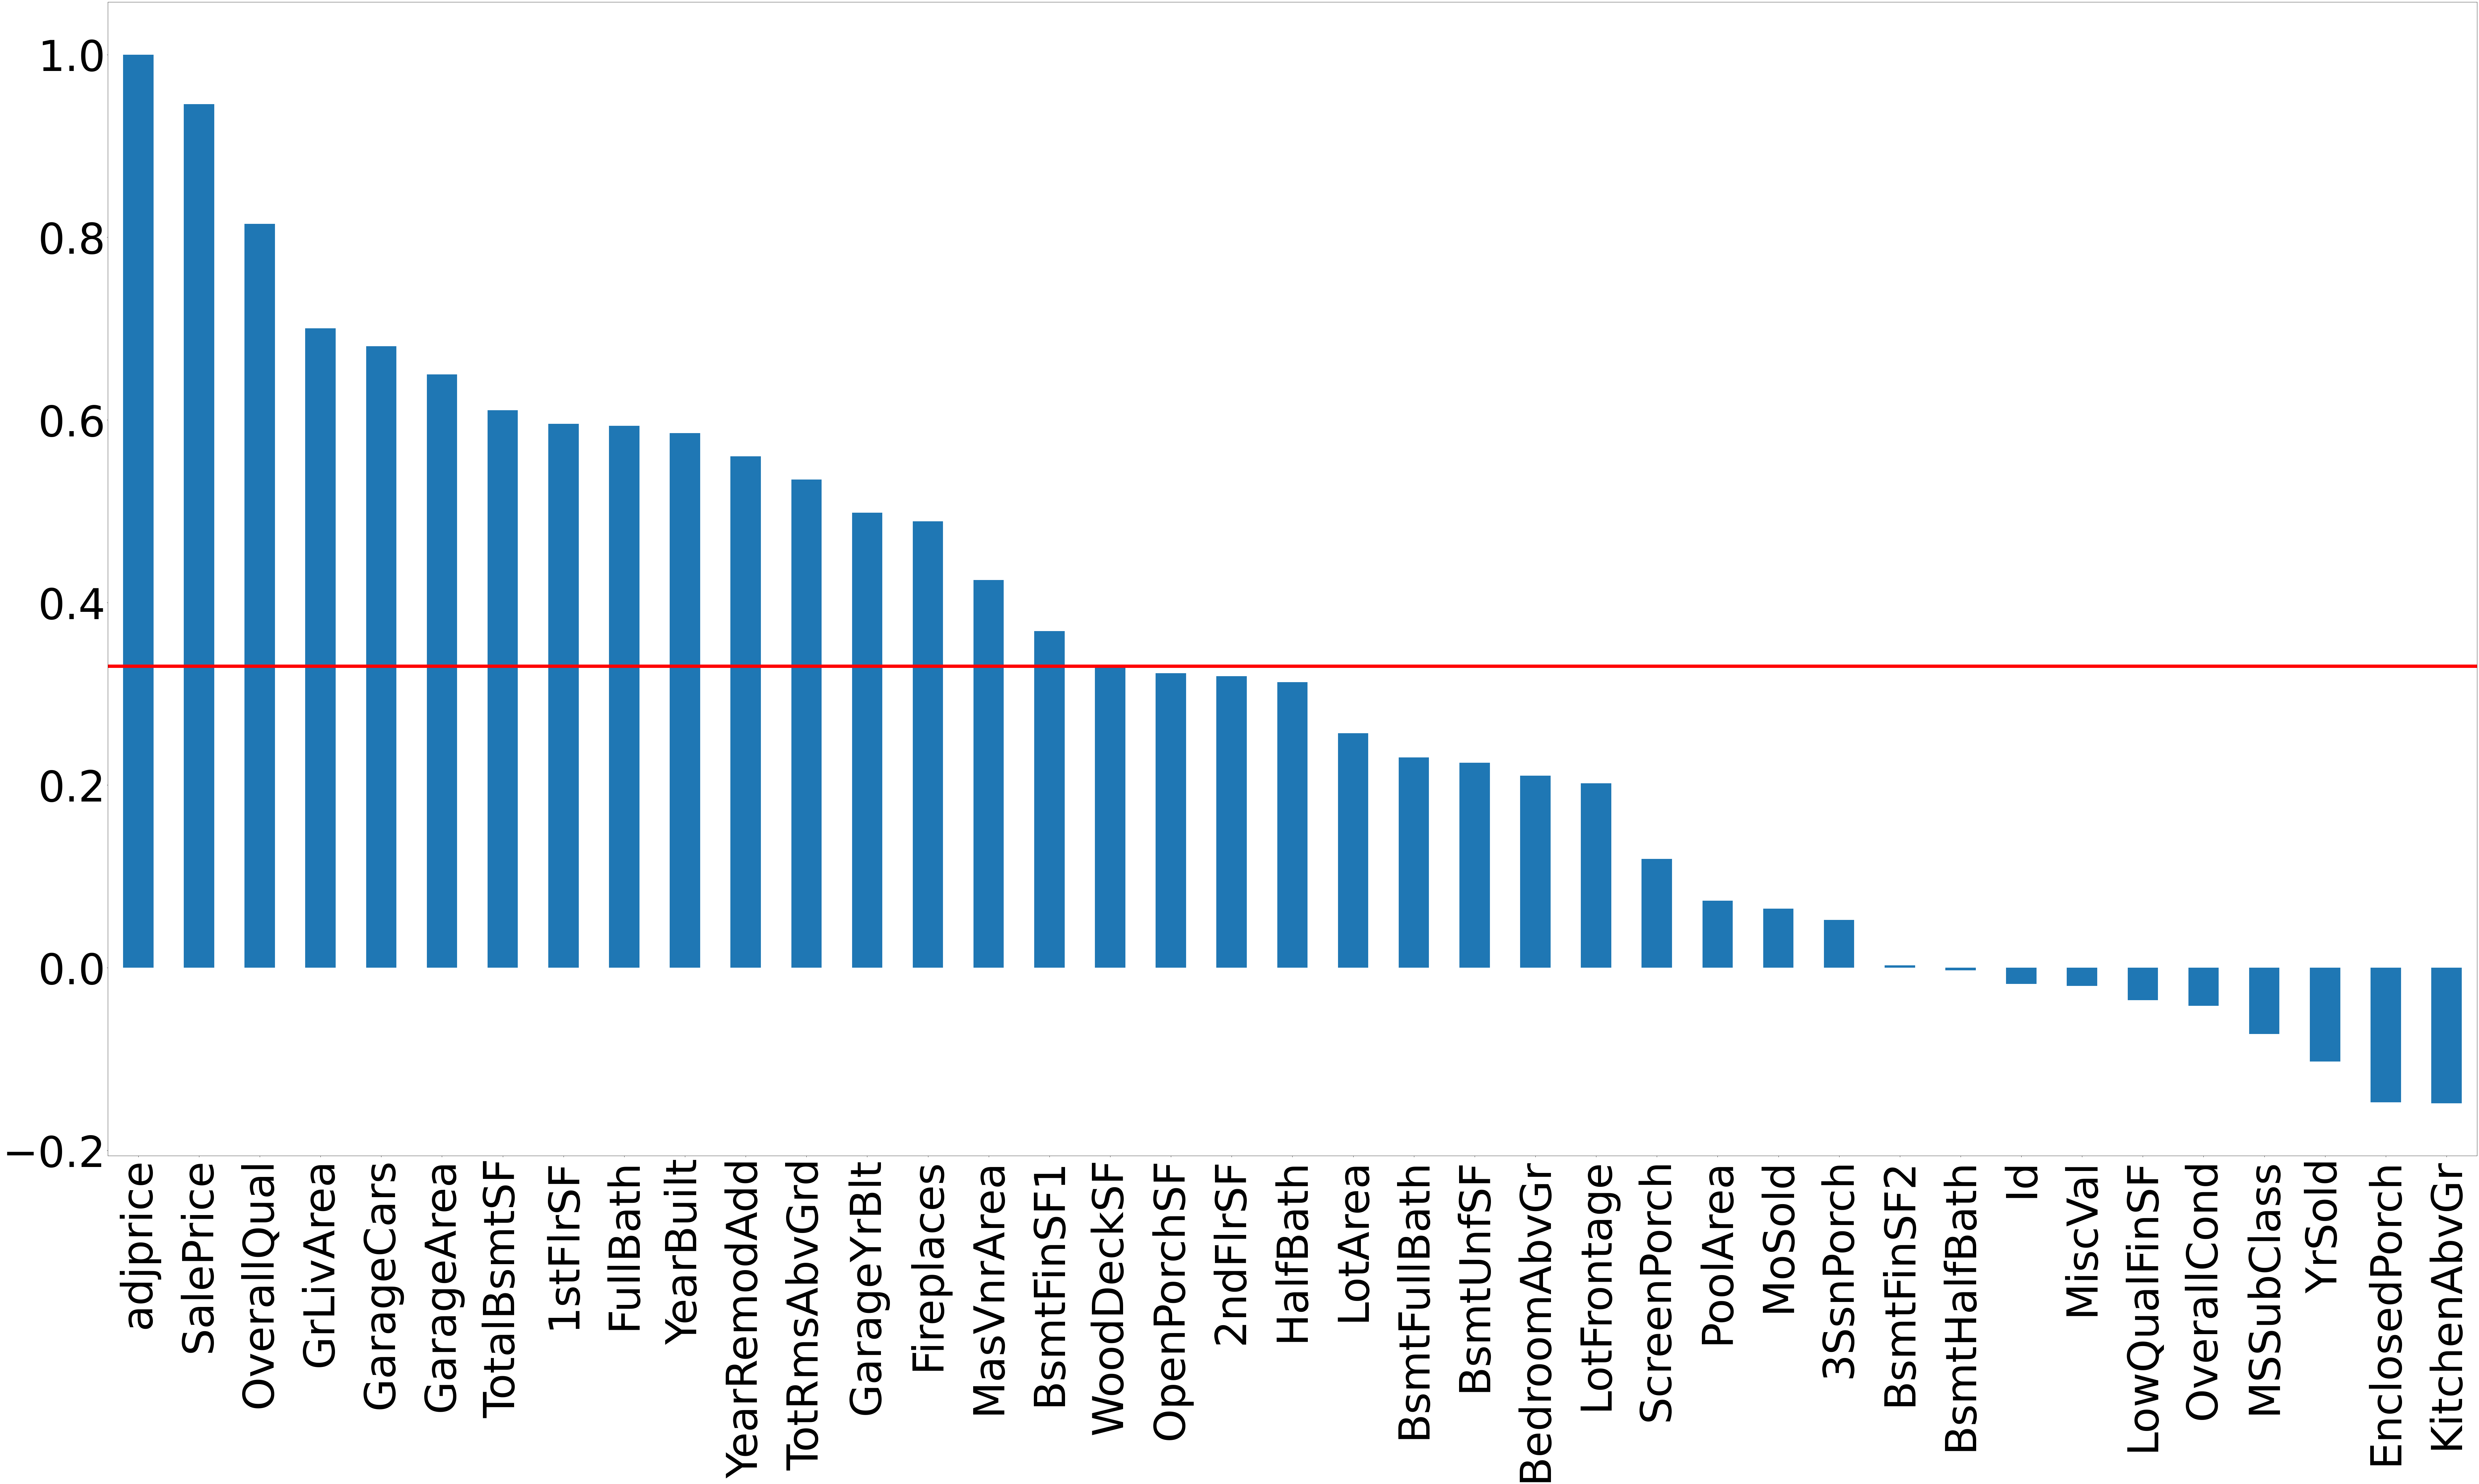

In [32]:
plt.figure(figsize=(128,64))
df.corr()['adjprice'].sort_values(ascending=False).plot(kind='bar')
plt.axhline(0.33,color = 'red',linewidth=10)
plt.tick_params(labelsize=128)
plt.show()

In [33]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

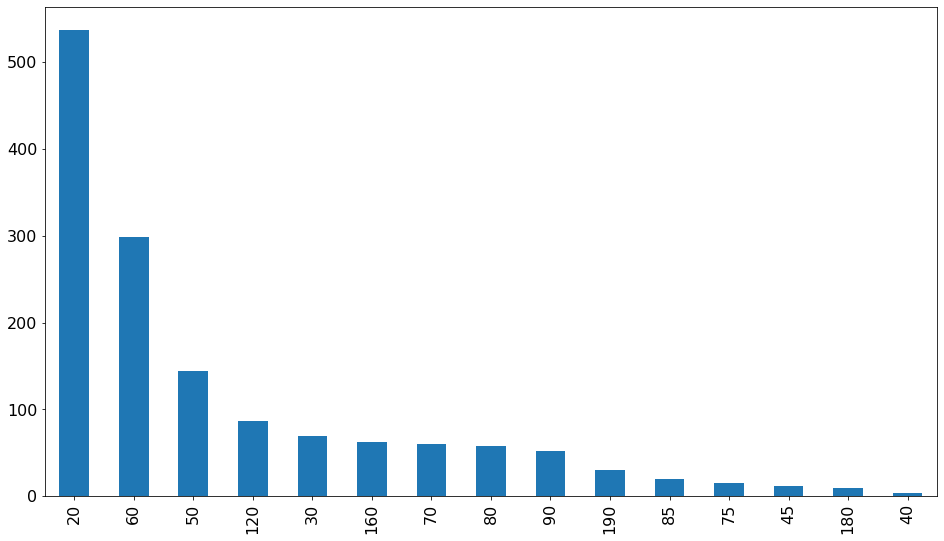

In [34]:
plt.figure(figsize=(16,9))
df['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

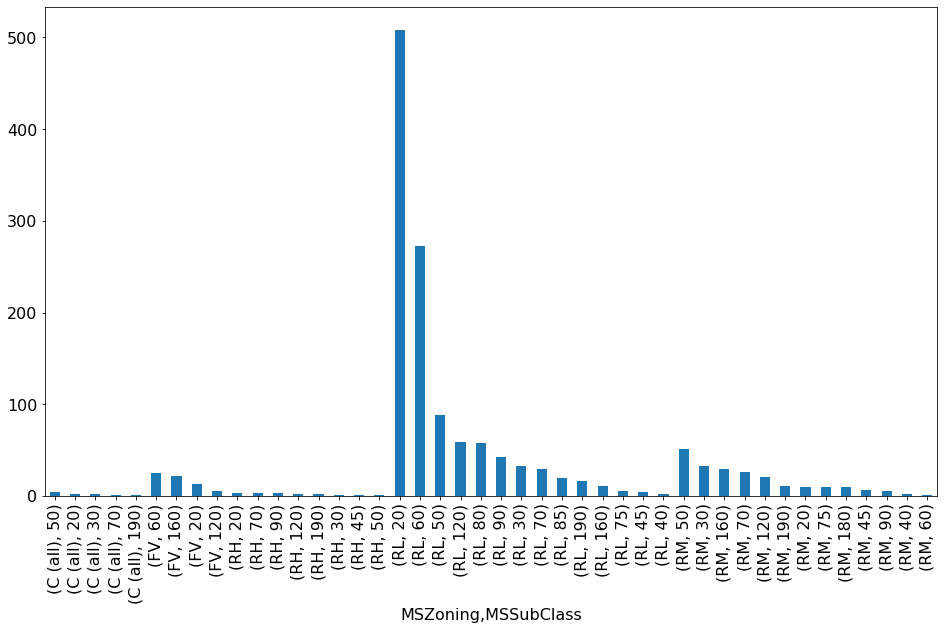

In [35]:
plt.figure(figsize=(16,9))
df.groupby('MSZoning')['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

In [36]:
def get_vecs(FEATURE, DATAFRAME, TARGET):
    vector = []
    variables = np.array(DATAFRAME.loc[:,FEATURE].value_counts().index,dtype=object)
    for i in range(len(variables)):
        vector.append(DATAFRAME[DATAFRAME.loc[:,FEATURE] == variables[i]][TARGET])
    return np.asarray(vector, dtype=object), variables

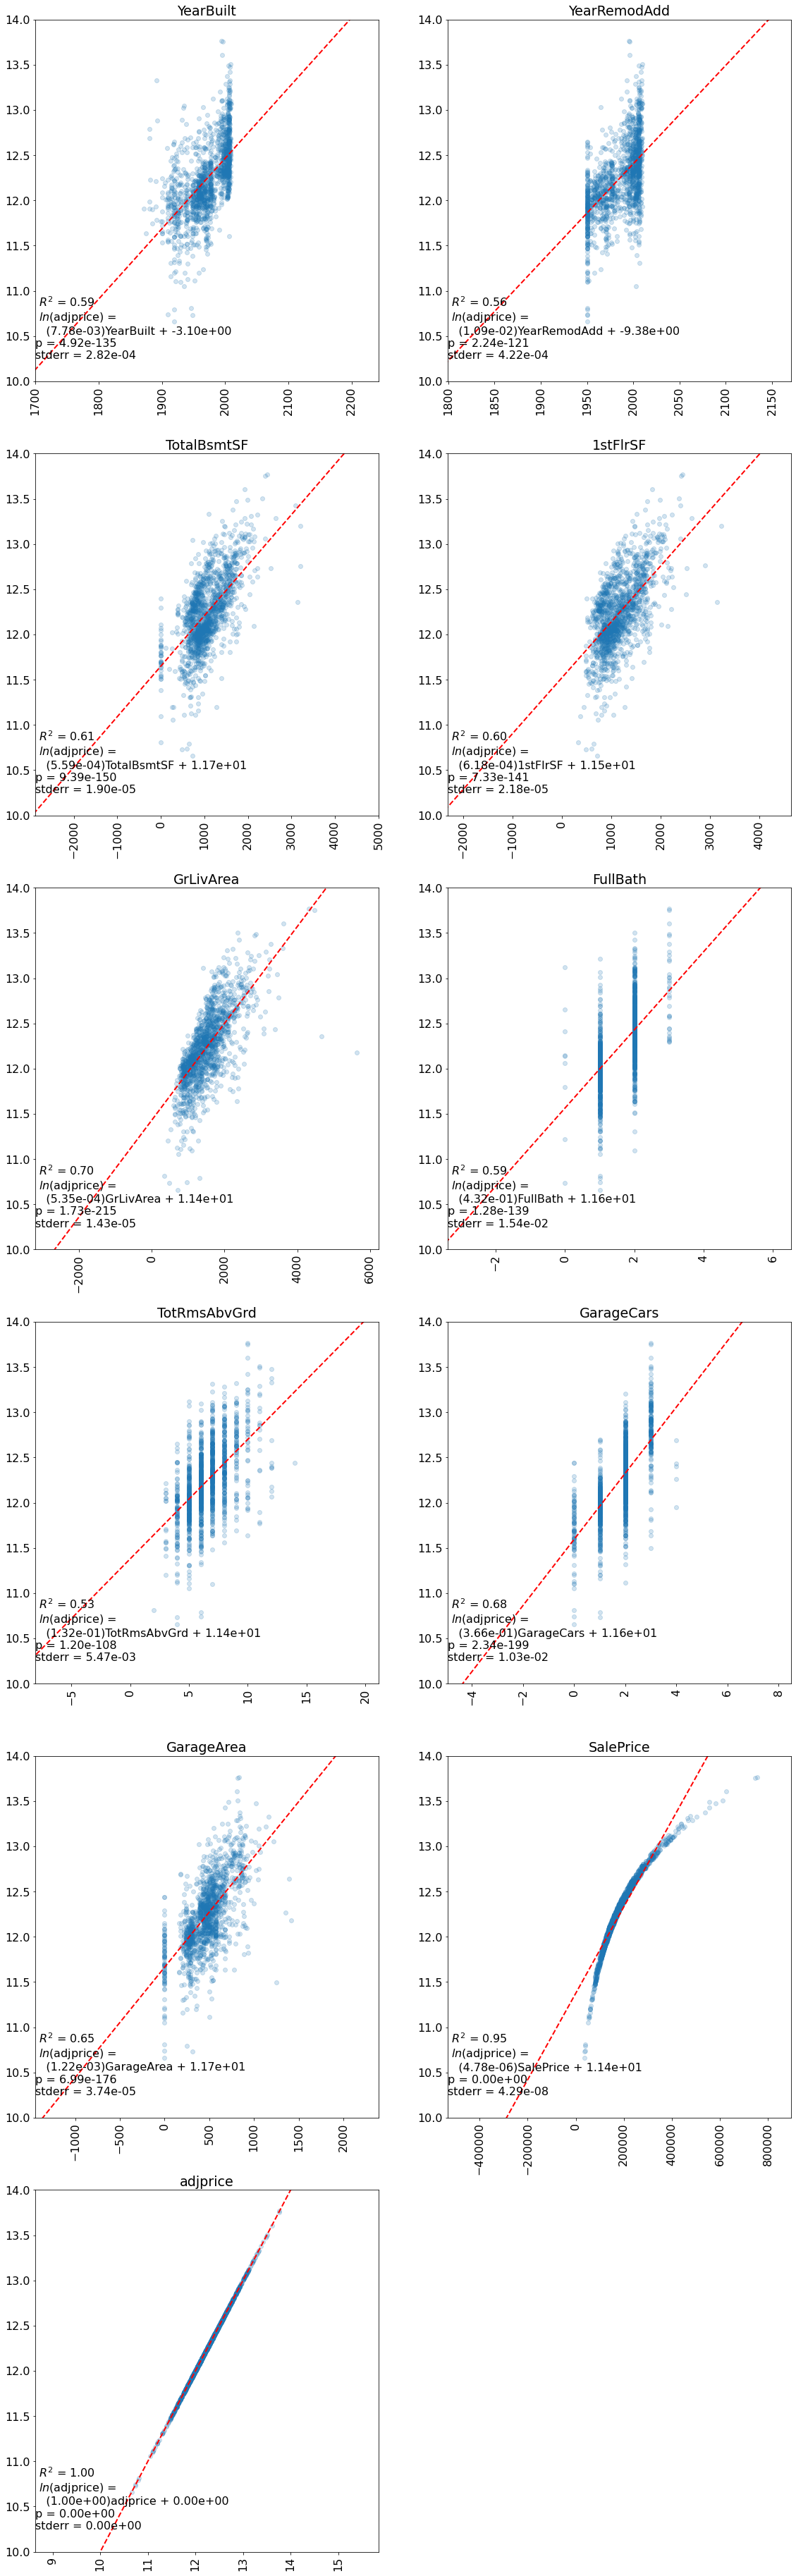

In [37]:
def bestfit(NUMERIC, TARGET):
    slope, intercept, r, p, std_err = stats.linregress(NUMERIC, TARGET)
    return slope, intercept

fig, axs = plt.subplots(figsize=(16,256))
fig.tight_layout()
j = 0
for i in range(1,len(numeric)):
    
    slope, intercept, r, p, std_err = stats.linregress(df[numeric[i]],df['adjprice'])
    if r >= 0.5:
        j = j+1
        devs = 9
        xmin = np.mean(df[numeric[i]]) - devs*np.std(df[numeric[i]])
        xmax = np.mean(df[numeric[i]]) + devs*np.std(df[numeric[i]])
        domain = np.linspace(-1e9,1e9,10)
        y_pred = slope*domain + intercept
        plt.subplot(30,2,j)
        plt.xlim(xmin,xmax)
        plt.ylim(10,14)
        plt.scatter(df[numeric[i]],df['adjprice'],alpha=0.2)
        plt.plot(domain,y_pred,c = 'r', linestyle='--',linewidth=2)
        plt.xticks(rotation=90)
        plt.text(xmin,10.25,
        f' $R^2$ = {r:.2f}\
        \n $ln$(adjprice) =\
        \n   ({slope:.2e}){numeric[i]} + {intercept:.2e}\
        \np = {p:.2e}\nstderr = {std_err:.2e}')
        plt.title(numeric[i])
    else:
        continue

plt.show()

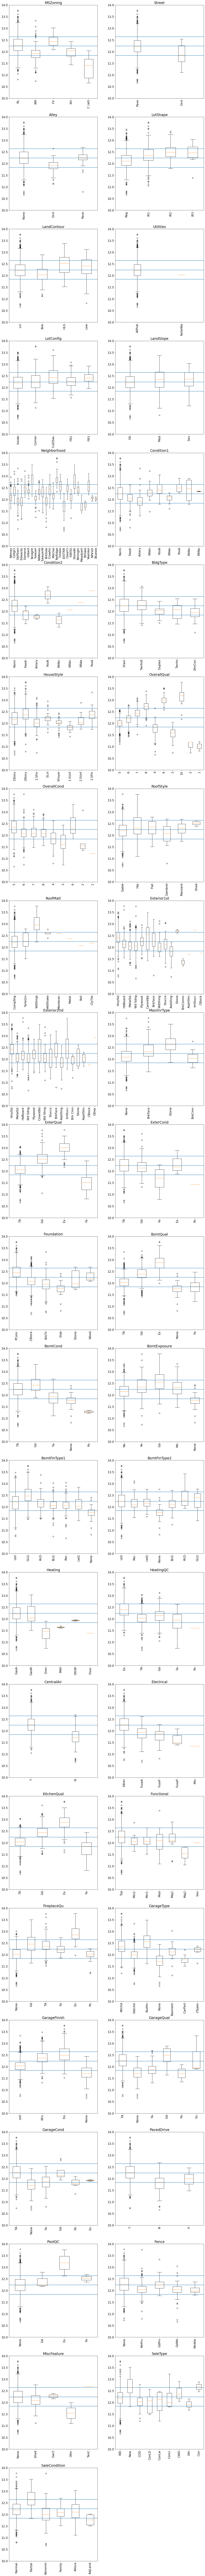

In [38]:
fig, ax = plt.subplots(figsize=(16,256))
fig.tight_layout()
for i in range(1,len(categoric)):
    vecs = get_vecs(categoric[i],df,'adjprice')
    plt.subplot(30,2,i)
    plt.ylim(10,14)
    plt.boxplot(vecs[0],labels=vecs[1])
    plt.xticks(rotation=90)
    plt.title(categoric[i])
    plt.axhline(df['adjprice'].mean(), c = 'C0')
    plt.axhline(df['adjprice'].mean() + np.std(df['adjprice']), c = 'C0')
    plt.axhline(df['adjprice'].mean() - np.std(df['adjprice']), c = 'C0')
plt.show()

In [39]:
def get_ranks(FEATURE, DATAFRAME, TARGET):
    ftr_mean = np.zeros(len(DATAFRAME[FEATURE].unique()))
    vecs = get_vecs(FEATURE, DATAFRAME, TARGET)
    for i in range(len(ftr_mean)):
        ftr_mean[i] = np.mean(vecs[0][i])
    ftr_rank = np.zeros(len(DATAFRAME),dtype=np.uint8)
    target_mean = np.mean(DATAFRAME[TARGET])
    target_std = np.std(DATAFRAME[TARGET])
    for i in range(len(df)):
        for j in range(len(vecs[1])):
            if DATAFRAME[FEATURE][i] == vecs[1][j]:
                if  ftr_mean[j] <= (target_mean - target_std):
                    ftr_rank[i] = 1
                if (ftr_mean[j] > (target_mean - target_std)) & (ftr_mean[j] <= target_mean):
                    ftr_rank[i] = 2
                if (ftr_mean[j] <= (target_mean + target_std)) & (ftr_mean[j] > target_mean):
                    ftr_rank[i] = 3
                if (ftr_mean[j] > (target_mean + target_std)):
                    ftr_rank[i] = 4
    return ftr_rank

In [40]:
#for i in range(len(df_model.columns)):
#    print("'"+df_model.columns[i]+"',")

#  Basic Model

In [41]:
# Begin by including all features in our model
df_model = pd.DataFrame()
for i in range(len(categoric)):
    try:
        tmp_str = categoric[i] + '_ranks'
        df_model.loc[:,tmp_str] = get_ranks(categoric[i],df,'adjprice')
    except:
        continue
df_cats = df.loc[:,numeric]
df_model = df_cats.merge(df_model, how='inner', left_index=True,right_index=True)
df_model = df_model.drop('SalePrice',axis=1)
df_model = df_model.drop('adjprice',axis=1)
df_model[0:5]

Id  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0   1         65.0     8450       2003          2003       196.0         706   
1   2         80.0     9600       1976          1976         0.0         978   
2   3         68.0    11250       2001          2002       162.0         486   
3   4         60.0     9550       1915          1970         0.0         216   
4   5         84.0    14260       2000          2000       350.0         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  GarageType_ranks  \
0           0        150          856  ...                 3   
1           0        284         1262  ...                 3   
2           0        434          920  ...                 3   
3           0        540          756  ...                 2   
4           0        490         1145  ...                 3   

   GarageFinish_ranks  GarageQual_ranks  GarageCond_ranks  PavedDrive_ranks  \
0                   3                 3                 3                 3   
1                   3                 3                 3                 3   
2                   3                 3                 3                 3   
3                   2                 3                 3                 3   
4                   3                 3                 3                 3   

   PoolQC_ranks  Fence_ranks  MiscFeature_ranks  SaleType_ranks  \
0             2            3                  3               2   
1             2            3                  3               2   
2             2            3                  3               2   
3             2            3                  3               2   
4             2            3                  3               2   

   SaleCondition_ranks  
0                    2  
1                    2  
2                    2  
3                    2  
4                    2  

[5 rows x 80 columns]

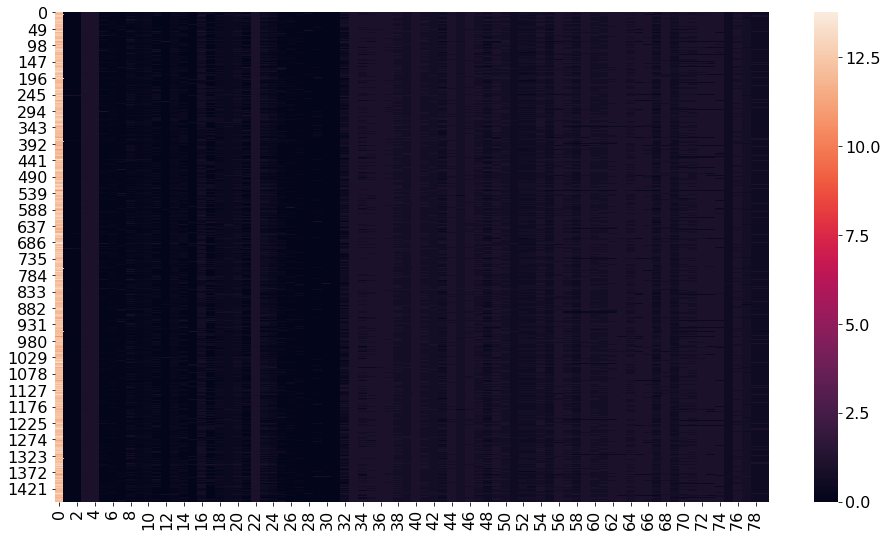

In [42]:
X = np.array(df_model,dtype = np.float64)
y = np.array(df.adjprice, dtype=np.float64)#df_model.iloc[:,0]


yX = np.array(df_model,dtype=np.float64)
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df['adjprice']

labels = list(df_model.columns)
labels[0] = 'adjprice'

plt.figure(figsize=(16,9))
sns.heatmap(yX[:,:])

In [43]:
stats.pearsonr(yX[:,i],yX[:,0])

(0.10624770643960132, 4.746713143055261e-05)

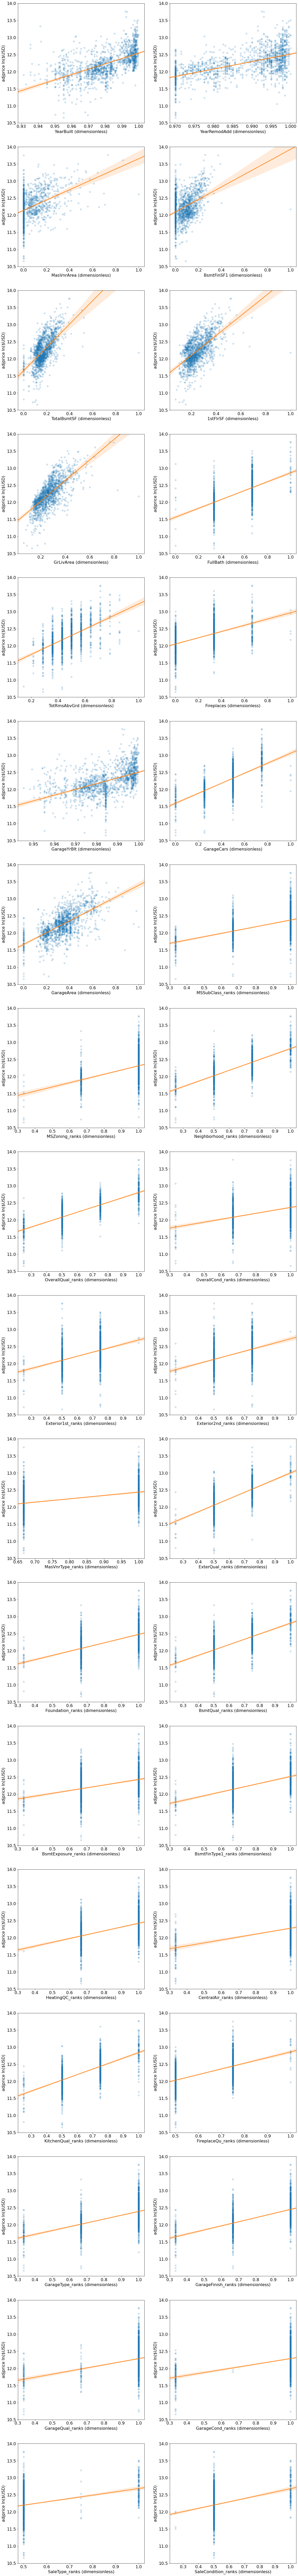

In [44]:
fig, ax = plt.subplots(figsize=(16,384))
fig.tight_layout()
j = 0
newcats = []
for i in range(1,len(labels)):
        if stats.pearsonr(yX[:,i],yX[:,0])[0] >= 1/3:
            j = j+1
            plt.subplot(50,2,j)
            ax = sns.regplot(yX[:,i], # X
                             yX[:,0], # y
                             scatter_kws={'alpha':0.2},
                             line_kws={'color':'C1'}
                            )
            ax.set(xlabel = labels[i]+' (dimensionless)',
                   ylabel = labels[0]+' ln($USD)',
                   ylim = (10.5,14)
                  )
            newcats.append(labels[i])
        else:
            continue
plt.show()

In [45]:
df_model = pd.merge(df.adjprice,df_model.loc[:,newcats],left_index=True,right_index=True)
print(df_model.columns)
print(df_model.shape)
df_model[0:5]

Index(['adjprice', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'MSSubClass_ranks', 'MSZoning_ranks', 'Neighborhood_ranks',
       'OverallQual_ranks', 'OverallCond_ranks', 'Exterior1st_ranks',
       'Exterior2nd_ranks', 'MasVnrType_ranks', 'ExterQual_ranks',
       'Foundation_ranks', 'BsmtQual_ranks', 'BsmtExposure_ranks',
       'BsmtFinType1_ranks', 'HeatingQC_ranks', 'CentralAir_ranks',
       'KitchenQual_ranks', 'FireplaceQu_ranks', 'GarageType_ranks',
       'GarageFinish_ranks', 'GarageQual_ranks', 'GarageCond_ranks',
       'SaleType_ranks', 'SaleCondition_ranks'],
      dtype='object')
(1460, 37)


adjprice  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
0  12.442396       2003          2003       196.0         706          856   
1  12.341389       1976          1976         0.0         978         1262   
2  12.511868       2001          2002       162.0         486          920   
3  12.109860       1915          1970         0.0         216          756   
4  12.623918       2000          2000       350.0         655         1145   

   1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  ...  HeatingQC_ranks  \
0       856       1710         2             8  ...                3   
1      1262       1262         2             6  ...                3   
2       920       1786         2             6  ...                3   
3       961       1717         1             7  ...                2   
4      1145       2198         2             9  ...                3   

   CentralAir_ranks  KitchenQual_ranks  FireplaceQu_ranks  GarageType_ranks  \
0                 3                  3                  2                 3   
1                 3                  2                  3                 3   
2                 3                  3                  3                 3   
3                 3                  3                  3                 2   
4                 3                  3                  3                 3   

   GarageFinish_ranks  GarageQual_ranks  GarageCond_ranks  SaleType_ranks  \
0                   3                 3                 3               2   
1                   3                 3                 3               2   
2                   3                 3                 3               2   
3                   2                 3                 3               2   
4                   3                 3                 3               2   

   SaleCondition_ranks  
0                    2  
1                    2  
2                    2  
3                    2  
4                    2  

[5 rows x 37 columns]

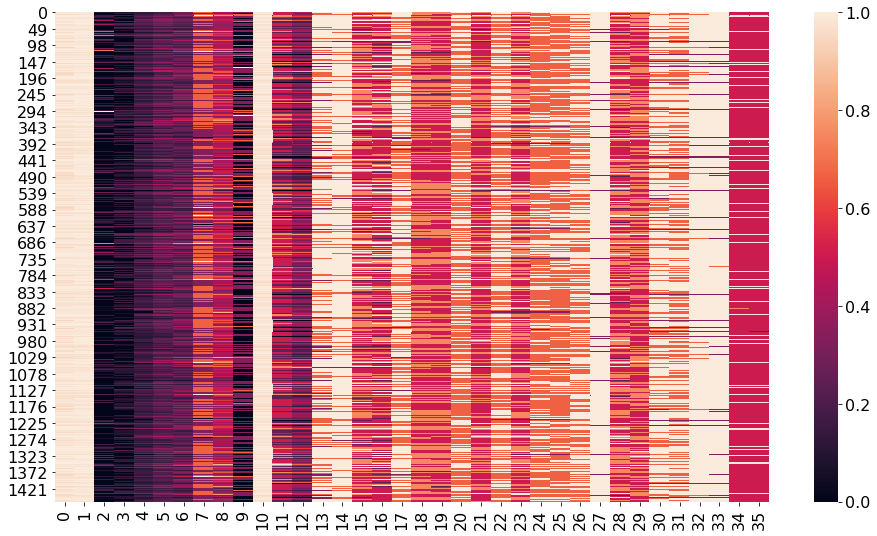

In [46]:
template = np.zeros((df_model.shape),dtype=np.float64)
yX_shm = SharedMemory(create=True, size=template.nbytes)
yX = np.ndarray(template.shape, dtype=template.dtype, buffer=yX_shm.buf)

yX[:] = np.array(df_model,dtype=np.float64)[:]
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df_model['adjprice']
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])

In [47]:
np.random.RandomState()

RandomState(MT19937) at 0x7274CB08B810

In [48]:
rng = np.random.default_rng()
rng.integers(1e9)

357442473

In [49]:
np.random.choice([True, False], size=len(X), p=[0.8, 0.2])

array([ True,  True,  True, ...,  True,  True,  True])

In [50]:
# MULTIPROCESSING DEFINTIONS

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY, WORK_INDEX):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[WORK_INDEX]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[WORK_INDEX] - distance
    return work_schedule


def score_model(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    y = INPUT[:,0]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        state = rng.integers(1e9)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = state)
        reg = MODEL_TYPE
        reg.fit(X_train, y_train)
        OUTPUT[0][i + OFFSET] = reg.score(X_test,y_test)
        OUTPUT[1][i + OFFSET] = np.sqrt(np.mean((np.exp(reg.predict(X_test)) - np.exp(y_test))**2))

            
def score_clusters(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        mask = rng.choice([True, False], size=len(X), p=[0.8, 0.2])
        X_masked = X[mask]
        cls = MODEL_TYPE
        cls.fit(X_masked)
        j = len(cls.cluster_centers_)
        OUTPUT[i + OFFSET][j] = cls.inertia_

"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT, TASK, MODEL_TYPE, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        #print(f'start {i}')
        p = Process(target=TASK, args=(INPUT,OUTPUT, MODEL_TYPE, WORK_SCHEDULE[i,0], WORK_SCHEDULE[i,1]))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        #print(f'join {i}')
        processes[i].join()

In [51]:
plt.plot(output[0])
plt.show()

NameError: name 'output' is not defined

In [52]:
len(kmeans.cluster_centers_)

NameError: name 'kmeans' is not defined

In [53]:
def draw_plots(MODEL_TYPE, WORKOUTPUT, BINS):
    plt.subplots(2,1,figsize=(16,16))
    xlab = ['$R^2$','RMSE\n($USD, adjusted for inflation 2021)']
    xlims = np.array(((0.6,1.0),
                    (0.0,180000.0)))
    for i in range(0,2):
        plt.subplot(2, 1, i + 1)
        plt.hist(WORKOUTPUT[i],bins=BINS)
        plt.title(f'{str(MODEL_TYPE)} (N={testlen:,})')
        plt.xlabel(xlab[i])
        plt.xlim(xlims[i,0],xlims[i,1])
        plt.ylabel('Frequency')
    plt.show()

    print('========')
    print(' Scores ')
    tmp = sp.stats.describe(WORKOUTPUT[0])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

    print('========')
    print(' Error  ')
    tmp = sp.stats.describe(WORKOUTPUT[1])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

Time Elapsed: 13.287s


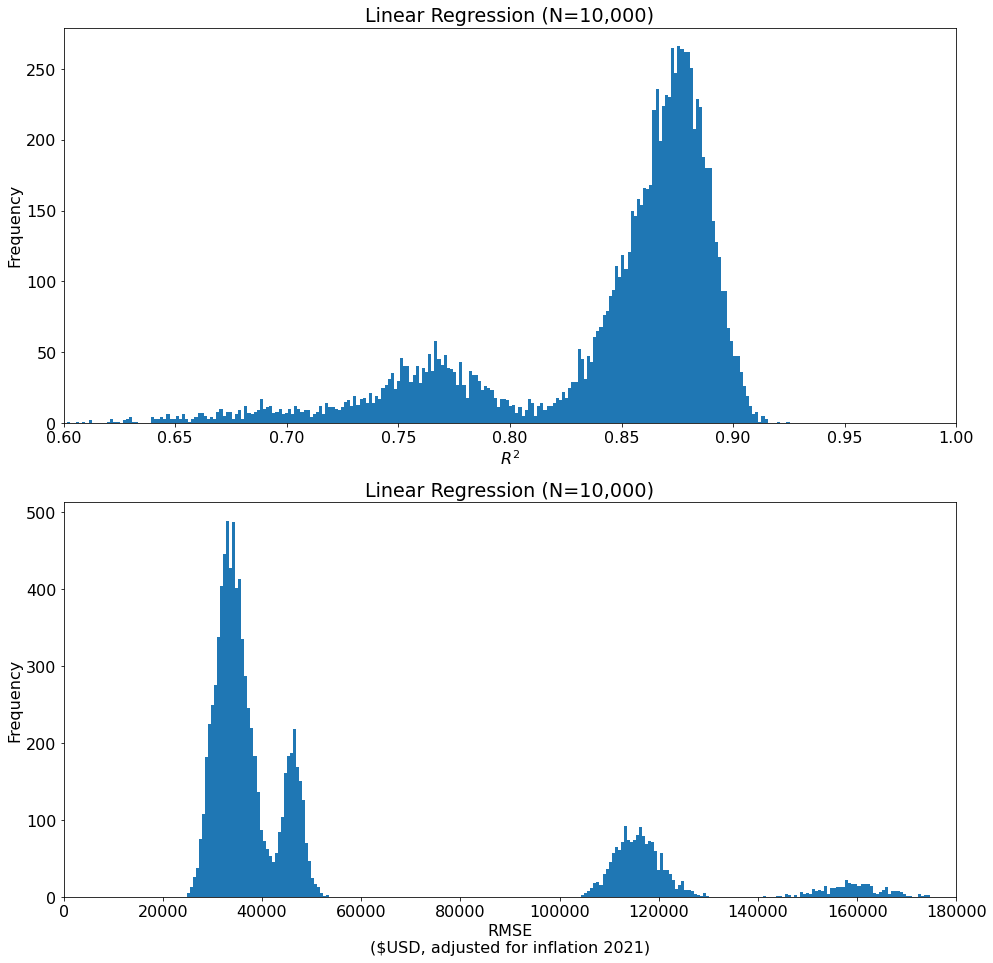

 Scores 
nobs:    	10000
minmax:  	(0.5762945405815715, 0.9252499084335719)
mean:    	0.8446551618847232
variance:	0.002996555335078737
skewness:	-1.5890446784781511
kurtosis:	1.9168268765429168
 Error  
nobs:    	10000
minmax:  	(23603.58440825586, 176580.99032490773)
mean:    	54358.58938244846
variance:	1353414954.963953
skewness:	1.6168619488912672
kurtosis:	1.1677492795673459


In [54]:
start_time = time()

testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = LinearRegression()
output = [scores,error]
job_list = divide_work(template, 0)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, score_model, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('Linear Regression',output,250)

#### The RMSE distribution is multimodal. This may indicate the presence of groups of samples with responses to the explanatory variables that are characteristic of that group. (Clusters) The four bumps in the RMSE distribution suggest the presense of four clusters.

## HYPOTHESIS: The data clusters best into four clusters.

#### Let's test different numbers of clusters and see what the best number of clusters is.

In [68]:
start_time = time()

testlen = 1000
clusters = 10

template = np.zeros((testlen,clusters),dtype=np.float64)
inertia_shm = SharedMemory(create=True, size=template.nbytes)
inertia = np.ndarray(template.shape, dtype=template.dtype, buffer=inertia_shm.buf)


output = inertia
job_list = divide_work(template,0)

start_time = time()
if __name__ == '__main__':
    for i in range(1,clusters):
        model = KMeans(n_clusters = i)
        assign_work(yX, score_clusters, model, job_list, output)
        sys.stdout.write(f'{i}\t {time() - start_time:.2f}s\n')
print(f'Time Elapsed: {time() - start_time:.3f}s')

#draw_plots('Linear Regression',output,250)

1	 6.35s
2	 21.10s
3	 43.85s
4	 70.10s
5	 100.69s
6	 133.00s
7	 169.95s
8	 210.34s
9	 254.45s
Time Elapsed: 254.447s


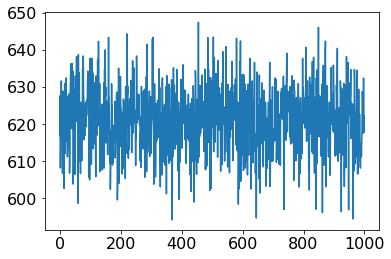

In [69]:
plt.plot(output[:,3])

## ELBOW METHOD!

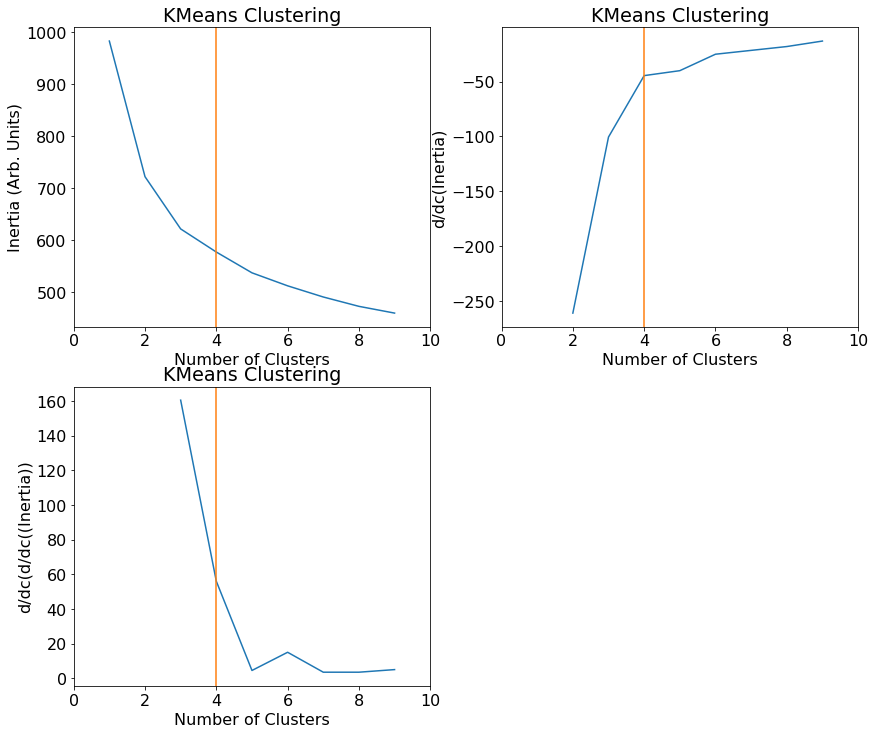

In [71]:
inertia_derivatives = np.zeros((clusters,3),dtype=np.float16)

ylabels = ['Inertia (Arb. Units)','d/dc(Inertia)', 'd/dc(d/dc((Inertia))']

for i in range(1,clusters):
    inertia_derivatives[i,0] = np.mean(output[:,i])
    inertia_derivatives[i,1] = inertia_derivatives[i,0] - inertia_derivatives[i-1,0]
    inertia_derivatives[i,2] = inertia_derivatives[i,1] - inertia_derivatives[i-1,1]
    
fig, ax = plt.subplots(figsize=(12,15))
fig.tight_layout()
for i in range(0,3):
    plt.subplot(3,2,i+1)
    plt.title('KMeans Clustering')
    plt.plot(np.arange(i+1,clusters),inertia_derivatives[(i+1):,i])
    plt.axvline(4,c='C1')
    plt.ylabel(str(ylabels[i]))
    plt.xlabel('Number of Clusters')
    plt.xlim(0,clusters)
plt.show()

### The second derivative of the inertia vs. number of clusters curve levels off around zero after four clusters. The hypothesis of four clusters we made by looking at the RMSE distribution cannot be rejected.

In [62]:
clusters = 4
testlen = 1460
kmeans = KMeans(n_clusters=clusters)
model = LinearRegression()
model.fit(yX[:,1:],yX[:,0])
centers = np.zeros((testlen,clusters))
start_time = time()
for i in range(0,testlen):
    rng = np.random.default_rng()
    mask = rng.choice([True, False], size=len(yX), p=[0.8, 0.2])
    X = yX[:,1:]
    X = X[mask]
    kmeans.fit(X)
    y_pred = model.predict(kmeans.cluster_centers_)
    for j in range(0,clusters):
        centers[i,j] = np.sort(np.exp(y_pred))[j]
print(f'Time Elapsed: {time() - start_time:.3f}s')

Time Elapsed: 146.158s


In [63]:
print(df_model.columns)
yX.shape

Index(['adjprice', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'MSSubClass_ranks', 'MSZoning_ranks', 'Neighborhood_ranks',
       'OverallQual_ranks', 'OverallCond_ranks', 'Exterior1st_ranks',
       'Exterior2nd_ranks', 'MasVnrType_ranks', 'ExterQual_ranks',
       'Foundation_ranks', 'BsmtQual_ranks', 'BsmtExposure_ranks',
       'BsmtFinType1_ranks', 'HeatingQC_ranks', 'CentralAir_ranks',
       'KitchenQual_ranks', 'FireplaceQu_ranks', 'GarageType_ranks',
       'GarageFinish_ranks', 'GarageQual_ranks', 'GarageCond_ranks',
       'SaleType_ranks', 'SaleCondition_ranks'],
      dtype='object')


(1460, 37)

In [66]:
kmeans.cluster_centers_[:,10]

array([0.97670984, 0.99591164, 0.97757834, 0.97986048])

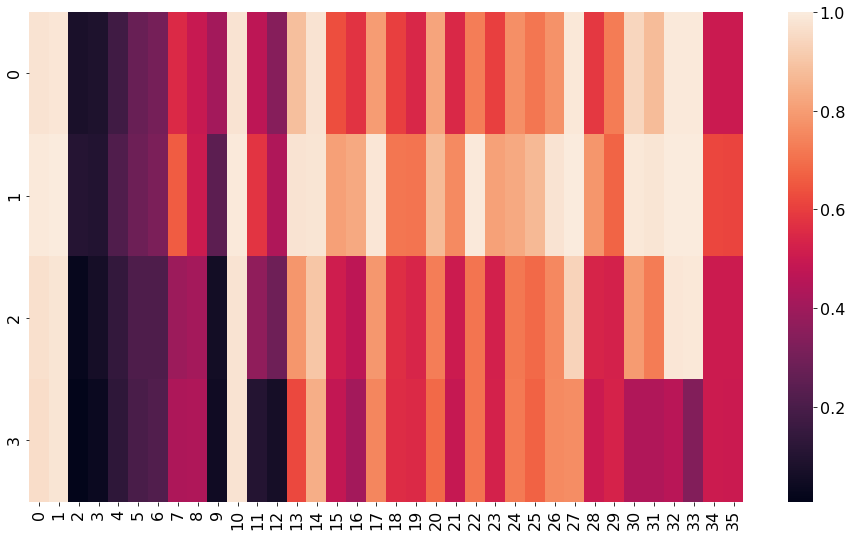

In [366]:
plt.figure(figsize=(16,9))
sns.heatmap(kmeans.cluster_centers_)
plt.show()

<BarContainer object of 4 artists>

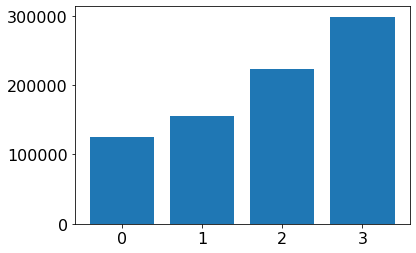

In [364]:
plt.bar(np.arange(0,4),np.sort(np.exp(y_pred)))

<function matplotlib.pyplot.show(*args, **kw)>

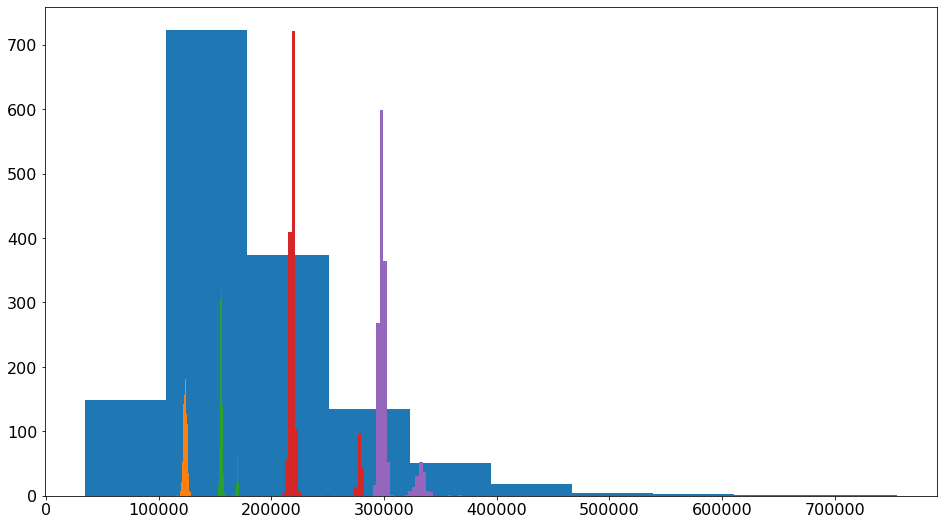

In [372]:
plt.figure(figsize=(16,9))
plt.hist(df.SalePrice,stacked=True)
for i in range(0,clusters):
    plt.hist(centers[:,i],bins=25)
plt.show

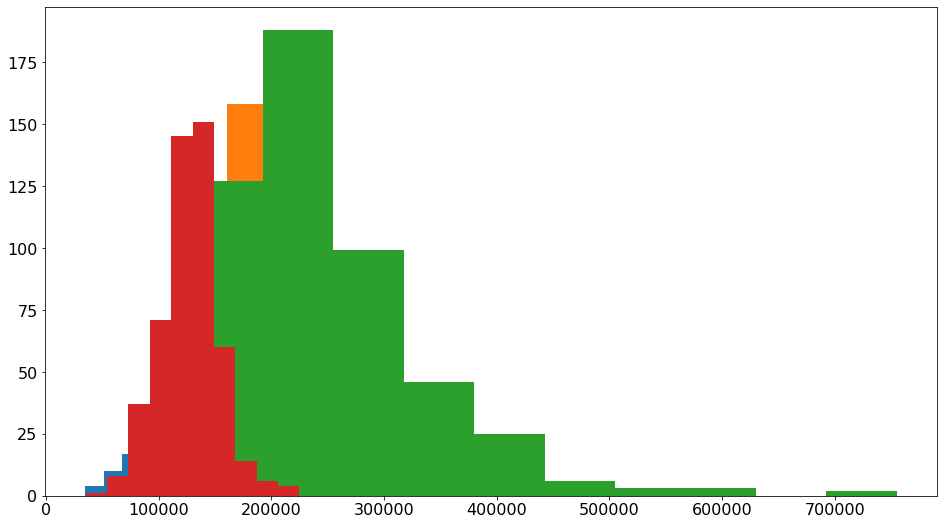

In [321]:
mask = np.random.choice([True, False], size=len(yX), p=[0.8, 0.2])
X = yX[:,1:]
X = X[mask]
X_mask = yX[np.invert(mask)][:,1:]

kmeans.fit(X)
df_model.loc[:,'cluster'] = kmeans.predict(yX[:,1:])
plt.figure(figsize=(16,9))
#plt.hist(df.SalePrice,bins= 20)
for i in range(0,clusters):
    plt.hist(df[df_model.cluster == i]['SalePrice'],stacked=True)
plt.show()

In [443]:
template = np.zeros((df_model.shape),dtype=np.float64)
ycX_shm = SharedMemory(create=True, size=template.nbytes)
ycX = np.ndarray(template.shape, dtype=template.dtype, buffer=ycX_shm.buf)

ycX[:] = np.array(df_clusters,dtype=np.float64)[:]
ycX = normalize(ycX, norm='max', axis=0)
ycX[:,0] = df_model['adjprice']
#plt.figure(figsize=(16,9))
#sns.heatmap(yX[:,1:])

In [71]:
testlen = 1000
neighbors = 15

min_error = 1e9
j_minerror = -1

max_score = -1
j_maxscore = -1

neighbor_error = np.zeros(neighbors, dtype=np.float64)
neighbor_score = np.zeros(neighbors, dtype=np.float64)

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)

output = [scores,error]
job_list = divide_work(template)

start_time = time()

if __name__ == '__main__': 
    for j in range(3,neighbors):
        sys.stdout.write(f'{j}\r')
        assign_work(yX, perform_work, KNeighborsRegressor(n_neighbors=j), job_list, output)
        
        neighbor_score[j] = output[0].mean()
        neighbor_error[j] = output[1].mean()
        if neighbor_score[j] > max_score:
            max_score = neighbor_score[j]
            j_maxscore = j
            #print(f'score {max_score} {j} {j_maxscore}')
        if neighbor_error[j] < min_error:
            min_error = neighbor_error[j]
            j_minerror = j
        else:
            continue


9


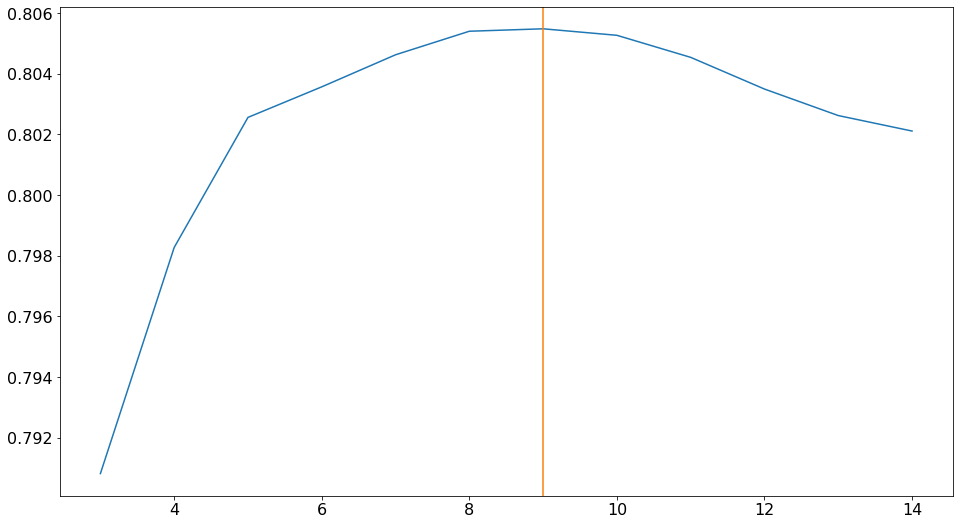

In [73]:
print(j_maxscore)
plt.figure(figsize=(16,9))
plt.plot(np.arange(3,neighbors),neighbor_score[3:])
plt.axvline(j_maxscore,c="C1")
plt.show()

5


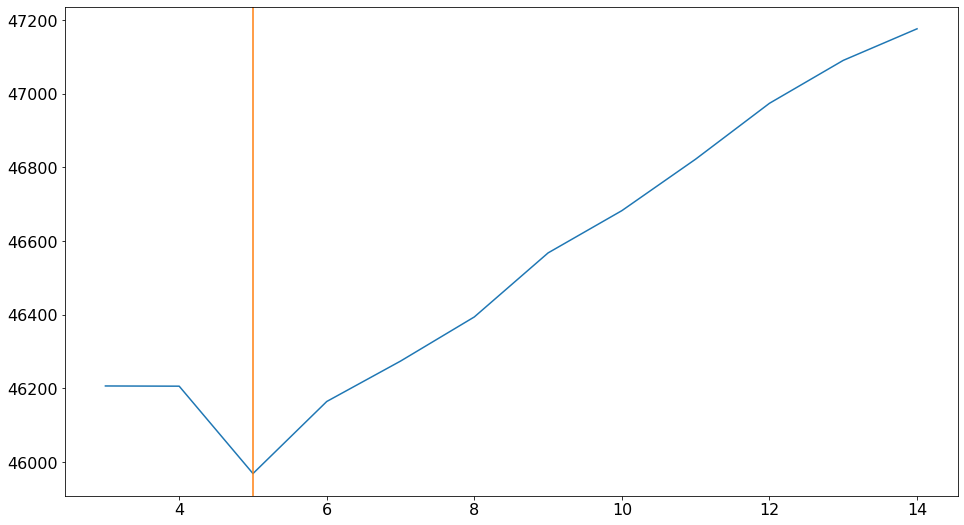

In [74]:
print(j_minerror)
plt.figure(figsize=(16,9))
plt.plot(np.arange(3,neighbors),neighbor_error[3:])
plt.axvline(j_minerror,c="C1")
plt.show()

Time Elapsed: 145.263s


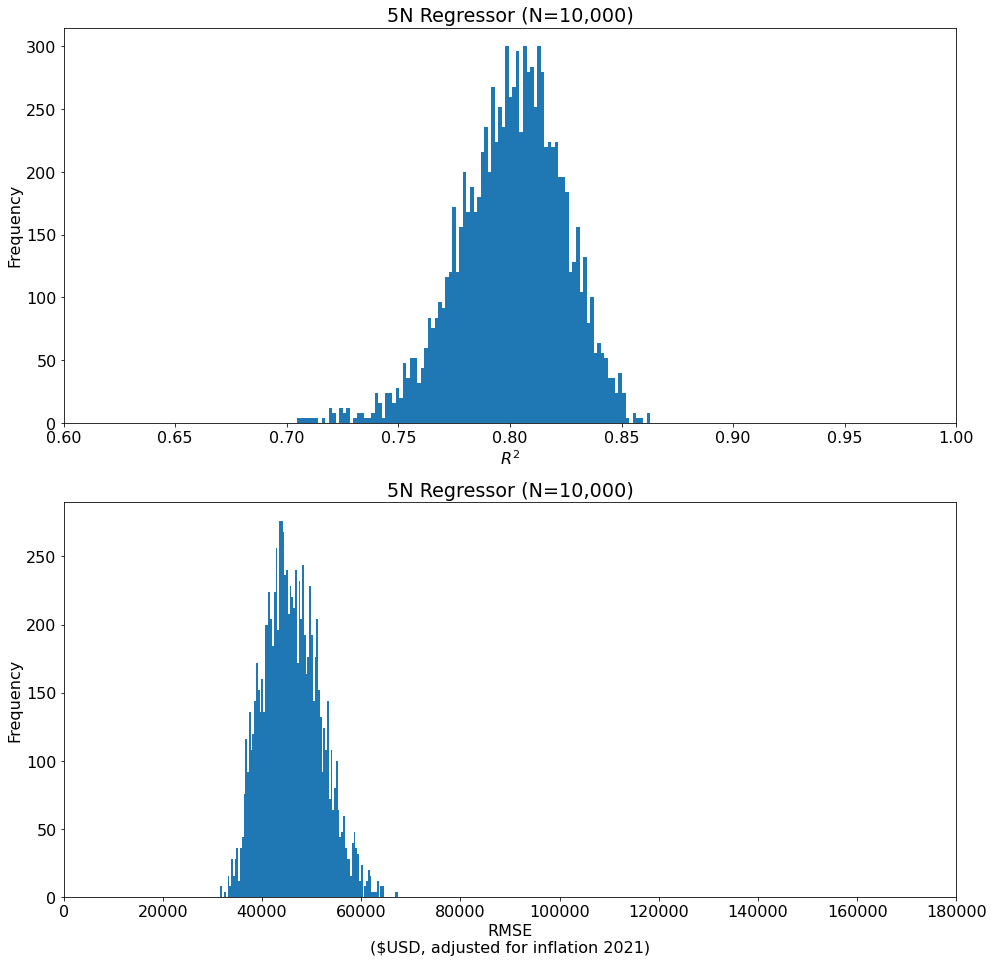

 Scores 
nobs:    	10000
minmax:  	(0.7045209114480285, 0.8628418824423228)
mean:    	0.800520919253039
variance:	0.0005509728499318042
skewness:	-0.48703683524329067
kurtosis:	0.5280736191192994
 Error  
nobs:    	10000
minmax:  	(31624.43820696659, 67439.72692486587)
mean:    	46042.79120097646
variance:	33249728.637052983
skewness:	0.3505498237914327
kurtosis:	-0.13690805598499933


In [76]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=j_minerror)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots(f'{j_minerror}N Regressor',output, int(np.sqrt(testlen)))

Time Elapsed: 156.053s


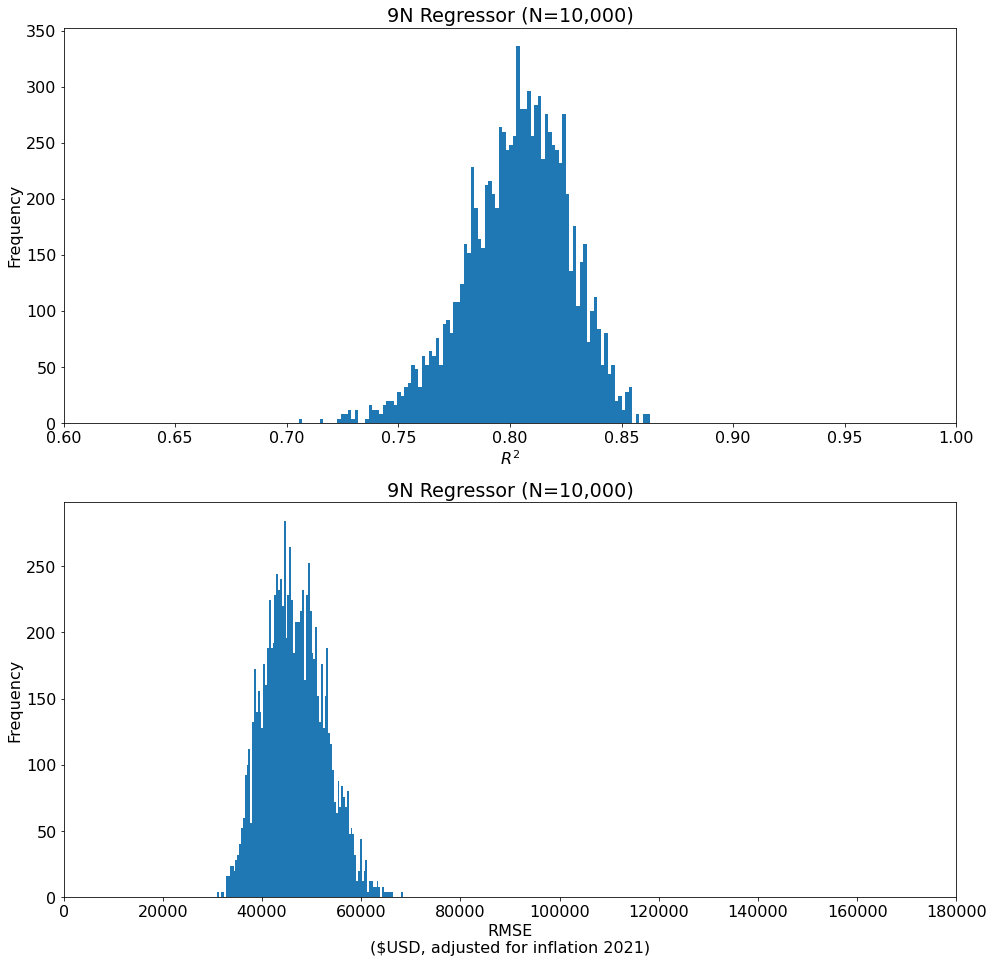

 Scores 
nobs:    	10000
minmax:  	(0.705314945120763, 0.8627418603449173)
mean:    	0.8034796477210395
variance:	0.0005272064290151402
skewness:	-0.45690125971087703
kurtosis:	0.31278733991138674
 Error  
nobs:    	10000
minmax:  	(30891.994750800703, 68353.31771845033)
mean:    	46576.2326657452
variance:	36615711.88334426
skewness:	0.27206270144886574
kurtosis:	-0.26004422665065974


In [77]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=j_maxscore)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots(f'{j_maxscore}N Regressor',output, int(np.sqrt(testlen)))

Time Elapsed: 1810.619s


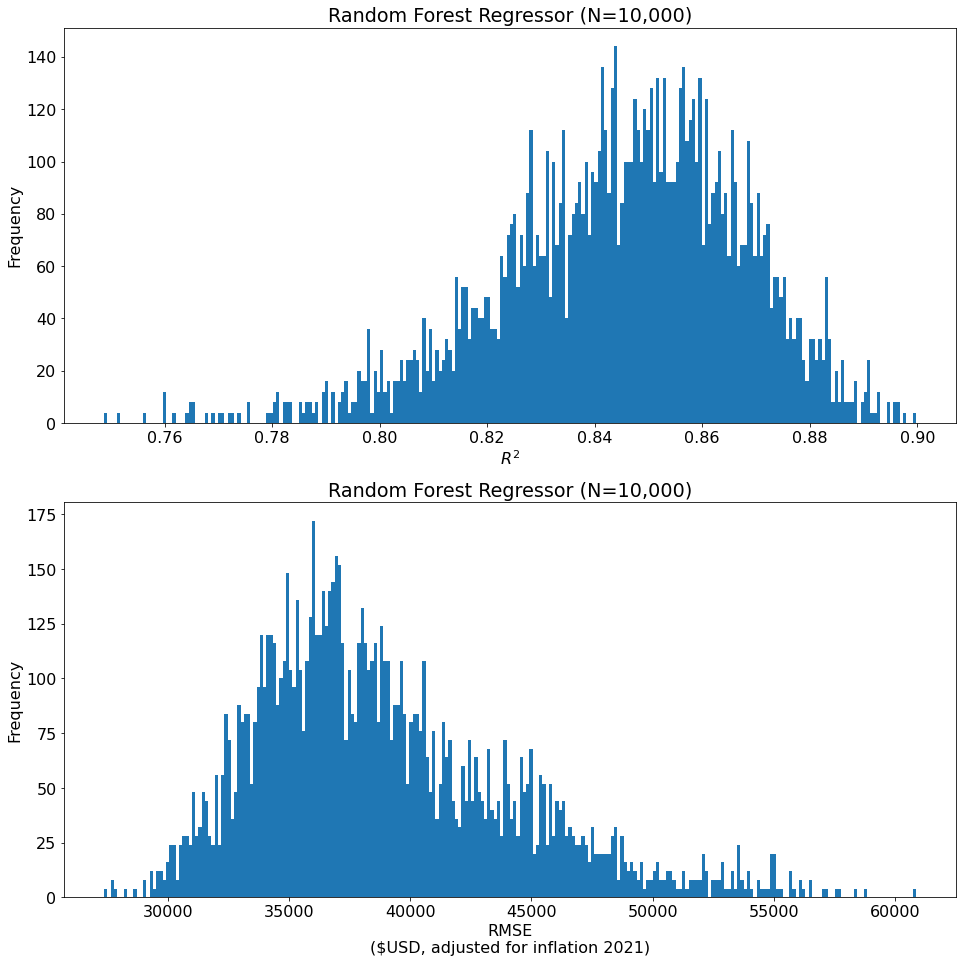

 Scores 
nobs:    	10000
minmax:  	(0.7487725555596703, 0.8997227385480598)
mean:    	0.8448949042953602
variance:	0.0005203906045594465
skewness:	-0.6206193150844479
kurtosis:	0.6269737667798942
 Error  
nobs:    	10000
minmax:  	(27372.753465149217, 60854.651258461214)
mean:    	38884.31328682293
variance:	28372209.463647053
skewness:	0.8928080595267504
kurtosis:	0.7142317734683856


In [412]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = RandomForestRegressor()
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('Random Forest Regressor',output, 250)

In [ ]:
draw_plots('Random Forest Regressor',output, 250)

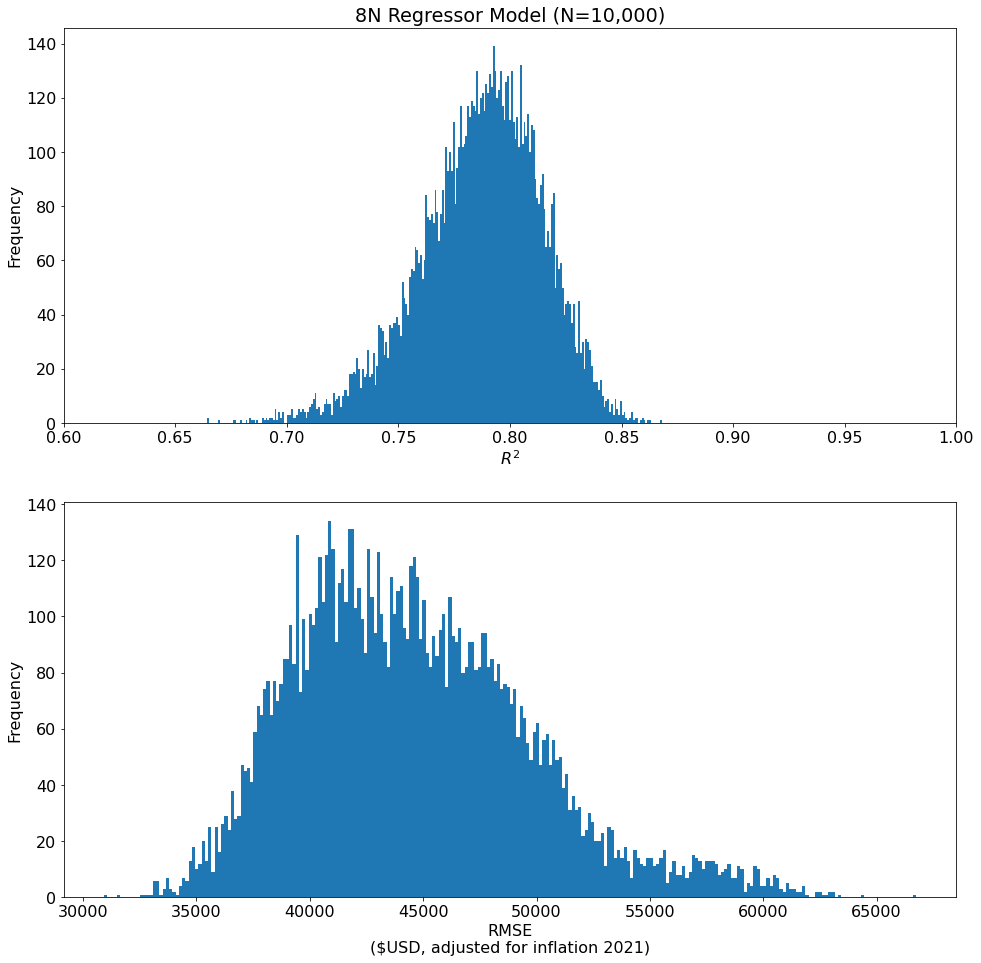

nobs:    	10000
minmax:  	(30929.365221740878, 66728.12362330407)
mean:    	44558.59968287939
variance:	26858203.256656744
skewness:	0.6351201039721451
kurtosis:	0.3445567898812283


0
count  10000.000000
mean       0.787097
std        0.027278
min        0.664410
25%        0.770399
50%        0.789370
75%        0.806225
max        0.868033

In [141]:
testlen = 10000
bins = 250#np.sqrt(testlen).astype(int)
neighbors = 8
scores = np.zeros(testlen,dtype=np.float64)
neighbor_error = np.zeros(neighbors, dtype=np.float64)
error = np.zeros(testlen,dtype=np.float64)
for i in range(0,testlen):
    tmp = []
    sys.stdout.write(f'{i}\r')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    kreg = KNeighborsRegressor()#n_neighbors = neighbors)
    kreg.fit(X_train,y_train)
    scores[i] = kreg.score(X_test, y_test)
    error[i] = np.sqrt(np.mean((np.exp(kreg.predict(X_test)) - np.exp(y_test))**2))

plt.subplots(2,1,figsize=(16,16))

plt.subplot(211)
plt.hist(np.array(scores,dtype=np.float64),bins=bins)
plt.title(f'8N Regressor Model (N={testlen:,})')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.6,1.0)

plt.subplot(212)
plt.hist(error,bins=bins)
#plt.title(f'Simple Linear Model (N={testlen:,})')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')

plt.show()

print('========')
print(' Scores ')
tmp = sp.stats.describe(scores)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

print('========')
print(' Error  ')
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

In [ ]:
testlen = 100000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=99)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('8N Regressor',output)

In [60]:
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

nobs:    	10000
minmax:  	(27731.76675935293, 69348.58071205845)
mean:    	43547.60744597859
variance:	34399180.86433528
skewness:	0.28009960510440074
kurtosis:	-0.16855984167044502


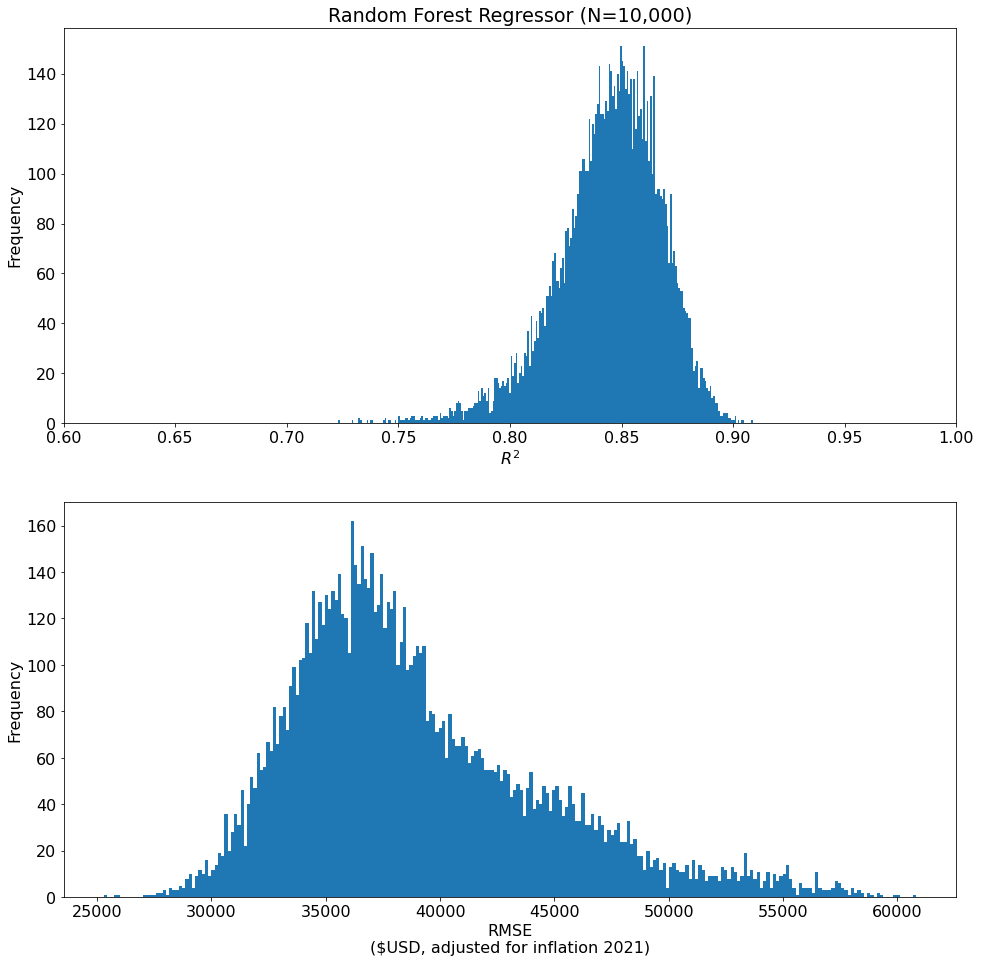

 Scores 
nobs:    	10000
minmax:  	(0.7231303974392453, 0.9087715675537853)
mean:    	0.8444923554224817
variance:	0.0005423812374974501
skewness:	-0.7372379729533589
kurtosis:	1.1164374443129725
 Error  
nobs:    	10000
minmax:  	(25307.01205921086, 60801.83386417476)
mean:    	38953.7403193029
variance:	30452851.059092287
skewness:	0.9457432132090695
kurtosis:	0.7570311722101608


In [143]:
testlen = 10000
scores = np.zeros(testlen,dtype=np.float64)
error = np.zeros(testlen,dtype=np.float64)
for i in range(0,testlen):
    sys.stdout.write(f'{i}\r')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rfreg = RandomForestRegressor(n_jobs=8)
    rfreg.fit(X_train,y_train)
    scores[i] = rfreg.score(X_test, y_test)
    error[i] = np.sqrt(np.mean((np.exp(rfreg.predict(X_test)) - np.exp(y_test))**2))

plt.subplots(2,1,figsize=(16,16))

plt.subplot(211)
plt.hist(np.array(scores,dtype=np.float64),bins=250)
plt.title(f'Random Forest Regressor (N={testlen:,})')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.6,1.0)

plt.subplot(212)
plt.hist(error,bins=250)
#plt.title(f'Simple Linear Model (N={testlen:,})')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')

plt.show()


print('========')
print(' Scores ')
tmp = sp.stats.describe(scores)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

print('========')
print(' Error  ')
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

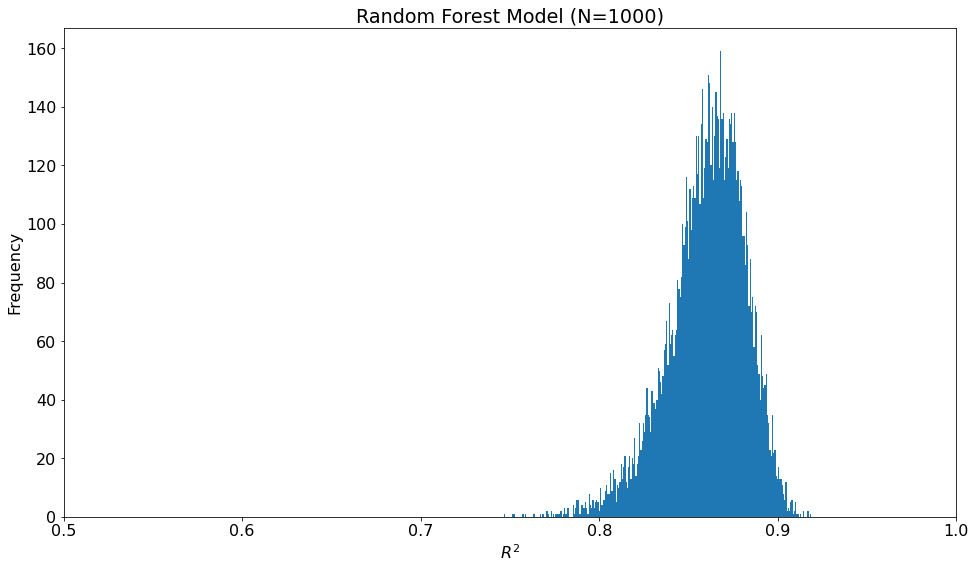

In [66]:
plt.figure(figsize=(16,9))
plt.hist(np.array(scores,dtype=np.float64),bins=250)
plt.title('Random Forest Model (N=1000)')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.5,1.0)
plt.show()

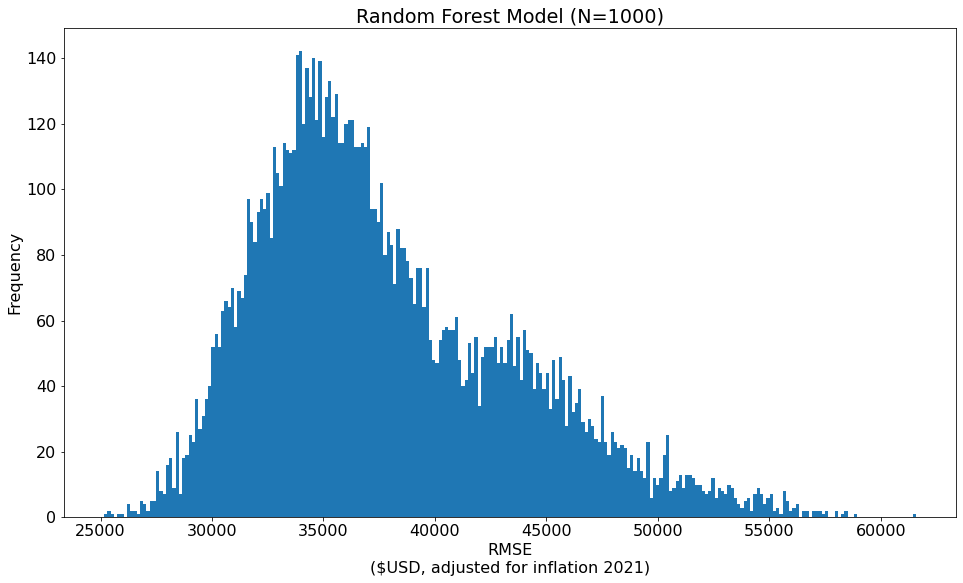

In [65]:
plt.figure(figsize=(16,9))
plt.hist(error,bins=250)
plt.title('Random Forest Model (N=1000)')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')
plt.show()

In [64]:
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

nobs:    	10000
minmax:  	(25163.392863858324, 61570.33429452338)
mean:    	37777.005566456464
variance:	32870228.596037276
skewness:	0.7830010753307908
kurtosis:	0.22372822653642777


In [66]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [68]:
(37777)/180921

0.20880384256111784